In [1]:
using QuantumOptics
using Plots
using LaTeXStrings
pyplot();

## Doppler cooling in a $\sigma^--\sigma^+$ molasses configuration
Intuitively, the picture of an atom decelerating in a negatively detuned running wave is simple: in the atom's frame the Doppler effect shifts the laser into resonance, the atom scatters photons, and it slows down. The Doppler shift is reduced, and gradually the atom falls out of resonance. In the co-moving frame, this can be described by a velocity-dependent detuning. Things become a little more complicated if there are beams coming from multiple directions, since then the Doppler shifts are different. In that case it might make more sense to describe everything in the lab frame; to practice with that, let's see if we can describe the effect of a single running wave in the lab frame first. 

We use the classical (velocity-dependent) force. In a way, it's a little artificial since we ignore the momentum in our calculation. This means that the atom will continue moving at the same velocity, regardless of the force that works on it. It is merely a calculational trick to find out what the instantaneous force $F$ is that works on an atom moving at velocity $v$ in the steady-state limit. If we would like to see how fast the atom slows down, we need to include the differential equations for position and momentum as well (which would be perfectly well possible, but it's not what we're after now). 

We'll assume a V-level diagram, with a single ground state, and two excited states, each of which is coupled by its own polarization.

#### Units
In cooling calculations it's convenient to express all frequencies in units of $\Gamma$, the natural line width. Furthermore, if we chose atomic units (by setting $\hbar = 1$) this means that we effectively solve $\tilde{\mathcal{H}}$, which is related to the original Hamiltonian $\mathcal{H}$ via: $\tilde{\mathcal{H}} = \mathcal{H}/\hbar\Gamma$.

Dropping the tildes, the Hamiltonian becomes:
$$
    \mathcal{H} = \frac{\Omega}{2} \left( e^{ikz} |e_-\rangle\langle g| + e^{-ikz} |g\rangle\langle e_-| + e^{-ikz} |e_+\rangle\langle g| + e^{ikz} |g\rangle\langle e_+| \right) - \delta \left( |e_-\rangle\langle e_-| + |e_+\rangle\langle e_+| \right).
$$
Here the frequencies $\Omega$ and $\delta$ are understood to be in units of $\Gamma$. This becomes apparent when we look at the jump operator $L$, which, in these units, is simply given by: $L = |g\rangle\langle e|$. (In full units it would carry a factor $\sqrt{\Gamma}$). The full evolution of the density matrix $\rho$ is now given by the master equation
$$
    i\frac{d\rho}{dt} = \left[\mathcal{H}, \rho \right] + L\rho L^\dagger - \frac{1}{2} \left\{ L^\dagger L, \rho \right\}.
$$
(But we don't really need to bother with that since QuantumOptics.jl will do it for us.)

In [21]:
δ = -1.;
Ω = 1.;
s₀ = 2 * Ω^2;

Set up a simple three-level basis that we can use to define operators. We use $\left\{ |g\rangle, |e_-\rangle, |e_+\rangle \right\}$.

In [22]:
sbasis = GenericBasis(3);

Define the Hamiltonian and force as dense operators. (We could also use `SparseOperator()`, but who really cares about that in a two-level system?) The force is defined clasically as
$$
    F = -\langle \nabla\mathcal{H} \rangle.
$$

In [23]:
H(z) = DenseOperator(sbasis, Ω / 2 * [0 exp(-im * z) exp(im * z); exp(im * z) 0 0; exp(-im * z) 0 0] - δ * [0 0 0; 0 1 0; 0 0 1])
F(z) = DenseOperator(sbasis, im * Ω / 2 * [0 exp(-im * z) -exp(im * z); -exp(im * z) 0 0; exp(-im * z) 0 0]);   # Force

Next define the quantum jump operators. There are two decay paths of equal strength. Recall that in our units the rate is simply 1:

In [24]:
rate = [1., 1.];
L = [SparseOperator(sbasis, complex(sparse([0 1. 0; 0 0 0; 0 0 0]))),
    SparseOperator(sbasis, complex(sparse([0 0 1.; 0 0 0; 0 0 0])))];
Ldagger = dagger.(L);

Define the initial condition and the time axis; these are the last ingredients needed for solving the master equation. We define a function that returns the force for some specified velocity:

In [25]:
ψ₀ = Ket(sbasis, [1, 0, 0]);
T = [0:0.01:20;]

function force(v)
    Hₜ = (t, ρ) -> (H(v * t), L, Ldagger);
    tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);
    return real(expect(F(tout[end] * v), ρₜ[end]))
end

force (generic function with 1 method)

#### Run and plot

In [26]:
vs = [-5:0.05:5;]
forces = force.(vs);

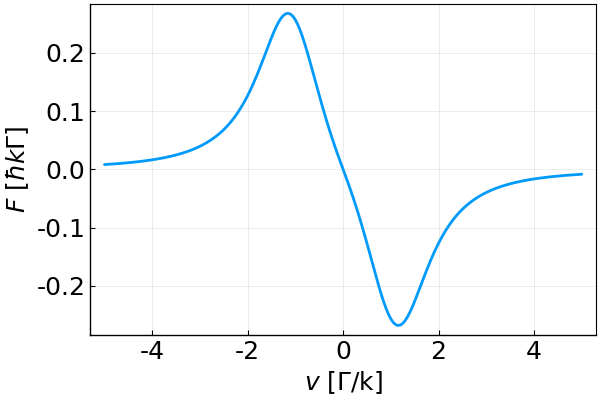

In [28]:
plot(vs, forces,
    width = 2,
#    xlims = (-1, 1),
    xlabel = L"$v$ [$\Gamma$/k]",
    ylabel = L"$F$ [$\hbar k\Gamma$]",
    frame = true,
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    label = "")

This was calculated for the same parameters as Fig. 7.1 from _Laser Cooling and Trapping_ by Metcalf and Van der Straten. Compare to their Fig 7.1:

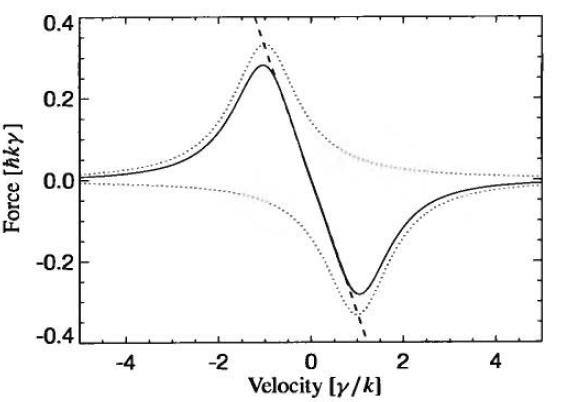

### Steady state convergence & behavior
How does the system converge to the steady state, and what are the population distributions there? (Actually, $s_0 = 2$, so there's a significant portion of population in the excited state.)

In [9]:
Hₜ = (t, ρ) -> (H(0 * t), L, Ldagger);
tout, ρₜ = timeevolution.master_dynamic(T, ψ₀, Hₜ; rates = rate);

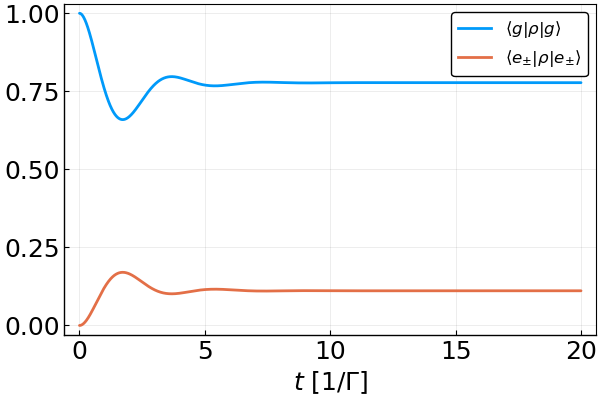

In [10]:
plot(tout, real(expect(DenseOperator(sbasis, [1. 0 0; 0 0 0; 0 0 0]), ρₜ)), label = L"$\langle g | \rho | g \rangle$", width = 2)
plot!(tout, real(expect(DenseOperator(sbasis, [0 0 0; 0 1. 0; 0 0 0]), ρₜ)), label = L"$\langle e_{\pm} | \rho | e_{\pm} \rangle$",
    frame = true,
    width = 2,
    xlabel = L"$t$ [$1/\Gamma$]",
    xtickfont = font(15),
    ytickfont = font(15),
    xaxis = font(18),
    yaxis = font(18),
    legendfont = font(12))